# Continous Frugal Flows

In this notebook we demonstrate the ability for Frugal Flows to identify Marginal Causal Effects

In [42]:
import sys
import os
sys.path.append("../") # go to parent dir

import jax
import jax.random as jr
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import numpy as np
from scipy.stats import rankdata
import scipy.stats as ss
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import KFold

# from data.create_sim_data import *
import data.template_causl_simulations as causl_py
from data.run_all_simulations import plot_simulation_results
from frugal_flows.causal_flows import independent_continuous_marginal_flow, get_independent_quantiles, train_frugal_flow
from frugal_flows.bijections import UnivariateNormalCDF

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage

# Activate automatic conversion of rpy2 objects to pandas objects
pandas2ri.activate()

# Import the R library causl
try:
    causl = importr('causl')
except Exception as e:
    package_names = ('causl')
    utils.install_packages(StrVector(package_names))

jax.config.update("jax_enable_x64", True)

hyperparams_dict = {
    'learning_rate': 1e-4,
    'RQS_knots': 8,
    'flow_layers': 5,
    'nn_width': 30,
    'nn_depth': 4,    
    'max_patience': 50,
    'max_epochs': 10000
}
causal_hyperparams = {
    'RQS_knots': 8,
    'flow_layers': 5,
    'nn_width': 50,
    'nn_depth': 4,   
}

SEED = 1
NUM_ITER = 1
NUM_SAMPLES = 5000
TRUE_PARAMS = {'ate': 1, 'const': 0, 'scale': 1}
CAUSAL_PARAMS = [0, 1]

In [2]:
def run_outcome_regression(data):
    df = pd.DataFrame(jnp.hstack([data['Y'], data['X']]), columns=['X', 'Y'])
    df['X'] = data['X']
    df['Y'] = data['Y']
    X_vars = df['X']
    X_vars = sm.add_constant(X_vars)
    Y_var = df['Y']
    model = sm.OLS(Y_var, X_vars).fit()
    coefficient_X = model.params['X']
    coefficient_const = model.params['const']
    return coefficient_X, coefficient_const

## Checking for the Causal Effect

### Gaussians

#### Frugal Flow

In [3]:
gaussian_covariates_results = causl_py.run_simulations(
    causl_py.generate_gaussian_samples, 
    seed=SEED, 
    num_samples=NUM_SAMPLES, 
    num_iter=NUM_ITER, 
    causal_params=CAUSAL_PARAMS,
    hyperparams_dict=hyperparams_dict,
    causal_model_args={'ate': 0., 'const': 1., 'scale': 1}
)

  1%|█▏                                                                                            | 132/10000 [01:08<1:24:44,  1.94it/s, train=-1.6883057150339513, val=-1.5791804973147907 (Max patience reached)]


In [4]:
gaussian_covariates_results

,ate,const,scale
0,0.952395,0.031008,1.019578
1,0.941517,0.059257,1.018826
2,1.004927,-0.003865,1.018104
3,0.947553,0.054648,1.025606
4,1.005962,0.014697,0.994957
5,0.929507,0.046192,1.037305
6,0.984675,0.019498,1.015737
7,0.949269,0.058575,1.023221
8,0.991620,-0.017333,1.007205
9,1.025170,-0.007617,1.006499


In [5]:
display(gaussian_covariates_results.mean())
display(gaussian_covariates_results.std())

ate      0.973260
const    0.025506
scale    1.016704
dtype: float64

ate      0.033045
const    0.028845
scale    0.011686
dtype: float64

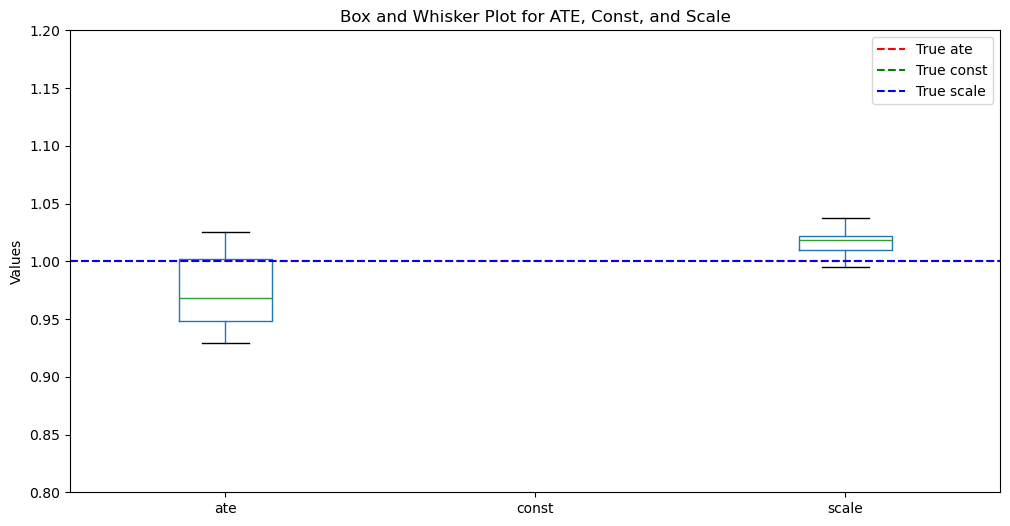

In [6]:
plt.figure(figsize=(12, 6))

# Boxplot
box = gaussian_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# Adding lines for the true parameters
plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# Adding title and labels
plt.title('Box and Whisker Plot for ATE, Const, and Scale')
plt.ylabel('Values')
plt.ylim([0.80, 1.20])
plt.legend()

#### Outcome Regression

In [7]:
gaussian_coeffs = {'ate': [], 'const': []}
for i in range(NUM_ITER):
    data = causl_py.generate_gaussian_samples(N=NUM_SAMPLES, causal_params=CAUSAL_PARAMS, seed=i)
    coeff_X, coeff_const = run_outcome_regression(data)
    gaussian_coeffs['ate'].append(coeff_X)
    gaussian_coeffs['const'].append(coeff_const)
gaussian_outcome_coeffs = pd.DataFrame.from_dict(gaussian_coeffs)
gaussian_outcome_coeffs

,ate,const
0,2.031925,-0.725165
1,2.020742,-0.721228
2,2.041646,-0.727061
3,2.018806,-0.706405
4,1.989711,-0.705807
5,2.051059,-0.733319
6,1.990568,-0.711508
7,2.007042,-0.702561
8,2.023868,-0.734764
9,2.069247,-0.750604


In [8]:
print(gaussian_outcome_coeffs.mean())
print(gaussian_outcome_coeffs.std())

ate      2.024461
const   -0.721842
dtype: float64
ate      0.025320
const    0.015415
dtype: float64


### Mixed Gaussian and Gamma Outcomes

In [29]:
Z_disc, Z_cont, X, Y = causl_py.generate_mixed_samples(10000, CAUSAL_PARAMS, 0).values()

In [30]:
uz_samples = causl_py.generate_uz_samples(Z_cont=Z_cont, use_marginal_flow=False, seed=0, frugal_flow_hyperparams=hyperparams_dict)

In [31]:
uz_disc_samples = uz_samples['uz_disc']
uz_cont_samples = uz_samples['uz_cont']

In [43]:
frugal_flow, losses = causl_py.train_frugal_flow(
    key=jr.PRNGKey(0),
    y=Y,
    u_z=uz_cont_samples,
    condition=X,
    **hyperparams_dict,
    causal_model='gaussian',
    causal_model_args={'ate': 0., 'const': 0., 'scale': 1}
)

  3%|███▎                                                                                             | 346/10000 [02:20<1:05:08,  2.47it/s, train=1.337391570761044, val=1.3766697983619065 (Max patience reached)]


In [44]:
causal_margin = frugal_flow.bijection.bijections[-1].bijection.bijections[0]

In [46]:
causal_margin.ate

Array(0.68690468, dtype=float64)

In [47]:
causal_margin.const

Array(0.31462514, dtype=float64)

In [5]:
continous_covariates_results = causl_py.run_simulations(
    causl_py.generate_mixed_samples, 
    seed=SEED, 
    num_samples=NUM_SAMPLES, 
    num_iter=NUM_ITER, 
    causal_params=CAUSAL_PARAMS,
    hyperparams_dict=hyperparams_dict,
    causal_model_args={'ate': 1., 'const': 1., 'scale': 1}
)

  1%|▋                                                                                                | 70/10000 [01:10<2:47:41,  1.01s/it, train=1.3112803863048401, val=1.4430655319829626 (Max patience reached)]

[array([0.61877404, 0.35233238, 1.00316714])]


In [6]:
continous_covariates_results

,ate,const,scale
0,0.618774,0.352332,1.003167


In [11]:
print(continous_covariates_results.mean())
print(continous_covariates_results.std())

ate      0.647032
const    0.352714
scale    1.027375
dtype: float64
ate      0.099384
const    0.105362
scale    0.008016
dtype: float64


#### Outcome Regression

In [12]:
outcome_coeffs = {'ate': [], 'const': []}
for i in range(NUM_ITER):
    data = causl_py.generate_mixed_samples(N=NUM_SAMPLES, causal_params=CAUSAL_PARAMS, seed=i)
    coeff_X, coeff_const = run_outcome_regression(data)
    outcome_coeffs['ate'].append(coeff_X)
    outcome_coeffs['const'].append(coeff_const)
outcome_coeffs = pd.DataFrame.from_dict(outcome_coeffs)
outcome_coeffs

,ate,const
0,2.453920,-1.426143
1,2.492001,-1.473425
2,2.530464,-1.493039
3,2.453804,-1.421090
4,2.410332,-1.403766
5,2.475346,-1.442975
6,2.272801,-1.267771
7,2.463572,-1.435156
8,2.511591,-1.491610
9,2.373293,-1.339113


In [13]:
print(outcome_coeffs.mean())
print(outcome_coeffs.std())

ate      2.443712
const   -1.419409
dtype: float64
ate      0.075535
const    0.069992
dtype: float64


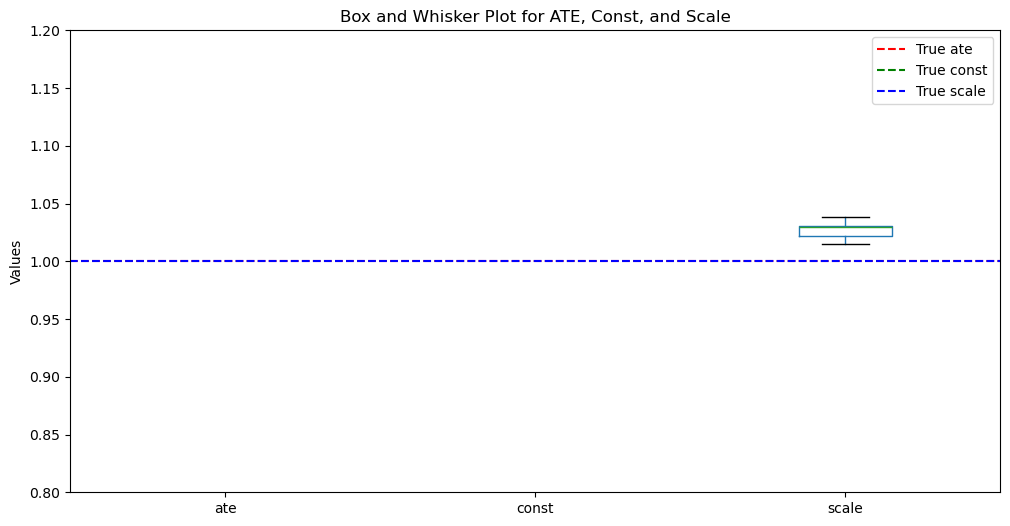

In [14]:
plt.figure(figsize=(12, 6))

# Boxplot
box = continous_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# Adding lines for the true parameters
plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# Adding title and labels
plt.title('Box and Whisker Plot for ATE, Const, and Scale')
plt.ylabel('Values')
plt.ylim([0.80, 1.20])
plt.legend()

### Mixed Continuous and Discrete (Small)

In [15]:
discrete_small_covariates_results = causl_py.run_simulations(
    causl_py.generate_discrete_samples, 
    seed=SEED, 
    num_samples=NUM_SAMPLES, 
    num_iter=NUM_ITER, 
    causal_params=CAUSAL_PARAMS,
    hyperparams_dict=hyperparams_dict,
    causal_model_args={'ate': 0., 'const': 1., 'scale': 1}
)

  1%|▊                                                                                                | 86/10000 [00:45<1:26:48,  1.90it/s, train=1.2712199351031772, val=1.4764220801014698 (Max patience reached)]


In [16]:
discrete_small_covariates_results

,ate,const,scale
0,0.902173,0.060606,0.997796
1,0.749413,0.161561,1.018782
2,0.874724,0.056250,0.988797
3,0.895951,0.053902,1.008424
4,0.898563,0.067606,1.007185
5,0.811648,0.104103,1.003270
6,0.886772,0.074704,1.006635
7,0.802862,0.117333,1.016233
8,0.794933,0.135381,1.007172
9,0.963911,0.021744,1.013845


In [17]:
print(discrete_small_covariates_results.mean())
print(discrete_small_covariates_results.std())

ate      0.858095
const    0.085319
scale    1.006814
dtype: float64
ate      0.065251
const    0.042957
scale    0.008837
dtype: float64


#### Outcome Regression

In [18]:
outcome_coeffs = {'ate': [], 'const': []}
for i in range(NUM_ITER):
    data = causl_py.generate_discrete_samples(N=NUM_SAMPLES, causal_params=CAUSAL_PARAMS, seed=i)
    coeff_X, coeff_const = run_outcome_regression(data)
    outcome_coeffs['ate'].append(coeff_X)
    outcome_coeffs['const'].append(coeff_const)
outcome_coeffs = pd.DataFrame.from_dict(outcome_coeffs)
outcome_coeffs

,ate,const
0,1.030409,-0.010012
1,1.009222,-0.006195
2,0.966494,0.005907
3,1.014426,-0.005735
4,1.017109,-0.009507
5,1.023951,-0.020754
6,1.029366,-0.019614
7,1.024277,-0.024517
8,1.029593,-0.016401
9,1.027913,-0.016856


In [19]:
print(outcome_coeffs.mean())
print(outcome_coeffs.std())

ate      1.017276
const   -0.012368
dtype: float64
ate      0.019232
const    0.009047
dtype: float64


In [20]:
plt.figure(figsize=(12, 6))

# Boxplot
box = discrete_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# Adding lines for the true parameters
plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# Adding title and labels
plt.title('Box and Whisker Plot for ATE, Const, and Scale')
plt.ylabel('Values')
plt.ylim([0.80, 1.20])
plt.legend()

NameError: name 'discrete_covariates_results' is not defined

<Figure size 1200x600 with 0 Axes>

### Mixed Continuous and Discrete (Large)

In [ ]:
discrete_big_covariates_results = causl_py.run_simulations(
    causl_py.generate_many_discrete_samples, 
    seed=SEED, 
    num_samples=NUM_SAMPLES, 
    num_iter=NUM_ITER, 
    causal_params=CAUSAL_PARAMS,
    hyperparams_dict=hyperparams_dict,
    causal_model_args={'ate': 0., 'const': 1., 'scale': 1}
)

In [ ]:
discrete_big_covariates_results

In [ ]:
print(discrete_big_covariates_results.mean())
print(discrete_big_covariates_results.std())

#### Outcome Regression

In [26]:
outcome_coeffs = {'ate': [], 'const': []}
for i in range(NUM_ITER):
    data = causl_py.generate_many_discrete_samples(N=NUM_SAMPLES, causal_params=CAUSAL_PARAMS, seed=i)
    coeff_X, coeff_const = run_outcome_regression(data)
    outcome_coeffs['ate'].append(coeff_X)
    outcome_coeffs['const'].append(coeff_const)
outcome_coeffs = pd.DataFrame.from_dict(outcome_coeffs)
outcome_coeffs

,ate,const
0,0.927802,0.031063
1,0.890988,0.063884
2,0.915400,0.044578


In [27]:
print(outcome_coeffs.mean())
print(outcome_coeffs.std())

ate      0.911397
const    0.046508
dtype: float64
ate      0.018730
const    0.016495
dtype: float64


In [ ]:
plt.figure(figsize=(12, 6))

# Boxplot
box = discrete_big_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# Adding lines for the true parameters
plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# Adding title and labels
plt.title('Box and Whisker Plot for ATE, Const, and Scale')
plt.ylabel('Values')
plt.ylim([0.80, 1.20])
plt.legend()

### Mixed Continuous and Discrete (Large and Sparse)

In [ ]:
discrete_sparse_covariates_results = causl_py.run_simulations(
    causl_py.generate_many_discrete_samples_sparse, 
    seed=SEED, 
    num_samples=NUM_SAMPLES, 
    num_iter=NUM_ITER, 
    causal_params=CAUSAL_PARAMS,
    hyperparams_dict=hyperparams_dict,
    causal_model_args={'ate': 0., 'const': 1., 'scale': 1}
)

In [ ]:
discrete_sparse_covariates_results

In [ ]:
print(discrete_sparse_covariates_results.mean())
print(discrete_sparse_covariates_results.std())

#### Outcome Regression

In [ ]:
outcome_coeffs = {'ate': [], 'const': []}
for i in range(NUM_ITER):
    data = causl_py.generate_many_discrete_samples(N=NUM_SAMPLES, causal_params=CAUSAL_PARAMS, seed=i)
    coeff_X, coeff_const = run_outcome_regression(data)
    outcome_coeffs['ate'].append(coeff_X)
    outcome_coeffs['const'].append(coeff_const)
outcome_coeffs = pd.DataFrame.from_dict(outcome_coeffs)
outcome_coeffs

In [ ]:
plt.figure(figsize=(12, 6))

# Boxplot
box = discrete_sparse_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# Adding lines for the true parameters
plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# Adding title and labels
plt.title('Box and Whisker Plot for ATE, Const, and Scale')
plt.ylabel('Values')
plt.ylim([0.80, 1.20])
plt.legend()